## What is my goal with this project?
As a citizen of Porto Alegre for more than 25 years I started to have the feeling that our weather is changing a little on these last years. Out of curiosity I wanted to visualize what differences are perceptible.

This is a simple project intended only to consolidate my knowledge of pandas, matplotlib and seaborn as I'm currently deepening my comprehension of them.

### What questions I'mm intending to answer?
* Did the mean temperature during the sumers of POA rose up in these last years?
* And did the mean temperature during the winters had any change?
* Did the max temp rose up during the sumemrs?

In [39]:
import numpy as np
import pandas as pd

In [40]:
# [Po]rto [A]legre [W]eather dataframe being loaded from the csv with ';' as separator
poaw = pd.read_csv('DATA_POA_2001-01-01_2022-03-11.csv',sep=';')
poaw.head()

,Data Medicao,"PRECIPITACAO TOTAL, DIARIO (mm)","TEMPERATURA MAXIMA, DIARIA (C)","TEMPERATURA MEDIA, DIARIA (C)","TEMPERATURA MINIMA, DIARIA (C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (%)","UMIDADE RELATIVA DO AR, MINIMA DIARIA (%)",Unnamed: 7
0,2001-01-01,0,"30,1","23,616667","18,4","68,458333",48.0,NaN
1,2001-01-02,0,"32,1","25,475",20,"69,958333",45.0,NaN
2,2001-01-03,0,"33,4","26,345833",21,"69,083333",43.0,NaN
3,2001-01-04,0,"35,5","27,429167","21,2","65,041667",37.0,NaN
4,2001-01-05,0,"35,6","27,6375","24,6","67,25",35.0,NaN


In [41]:
# Drop the last and useless column
poaw.drop(labels='Unnamed: 7',axis=1,inplace=True)

In [42]:
# For simplification and translation purposes I will change the columns names
new_col_names = ['Date',
                 'Total Precip',
                 'Max Temp','Average Temp',
                 'Min Temp',
                 'Avg Relative Humidity',
                 'Min Relative Humidity']

poaw.columns = new_col_names

In [43]:
poaw.head()

,Date,Total Precip,Max Temp,Average Temp,Min Temp,Avg Relative Humidity,Min Relative Humidity
0,2001-01-01,0,"30,1","23,616667","18,4","68,458333",48.0
1,2001-01-02,0,"32,1","25,475",20,"69,958333",45.0
2,2001-01-03,0,"33,4","26,345833",21,"69,083333",43.0
3,2001-01-04,0,"35,5","27,429167","21,2","65,041667",37.0
4,2001-01-05,0,"35,6","27,6375","24,6","67,25",35.0


In [44]:
#Convert the "Date" col to datetime type and the other cols to float type (the last col is already float)
poaw['Date'] = pd.to_datetime(poaw['Date'])

#List with all the cols to be changed from str to float
cols_to_float = ['Total Precip', 'Max Temp', 'Average Temp', 'Min Temp', 'Avg Relative Humidity']

poaw[cols_to_float] = poaw[cols_to_float].apply(lambda x: x.str.replace(',','.').astype(float))

#non used trash
#poaw['Max Temp'] = poaw.iloc[:,2:3].apply(lambda x: x.str.replace(',','.').astype(float))
#poaw['Average Temp'] = poaw.iloc[:,3:4].apply(lambda x: x.str.replace(',','.').astype(float))
#poaw['Min Temp'] = poaw.iloc[:,4:5].apply(lambda x: x.str.replace(',','.').astype(float))
#poaw['Avg Relative Humidity'] = poaw.iloc[:,5:6].apply(lambda x: x.str.replace(',','.').astype(float))

In [45]:
poaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7740 entries, 0 to 7739
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   7740 non-null   datetime64[ns]
 1   Total Precip           7210 non-null   float64       
 2   Max Temp               7448 non-null   float64       
 3   Average Temp           7232 non-null   float64       
 4   Min Temp               7453 non-null   float64       
 5   Avg Relative Humidity  7529 non-null   float64       
 6   Min Relative Humidity  7628 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 423.4 KB


In [64]:
#Droping rows where there are at least 3 NaN
poaw.dropna(thresh=3, inplace=True)
#Setting the date as index
poaw.set_index('Date',inplace=True)

## Visualizing

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")

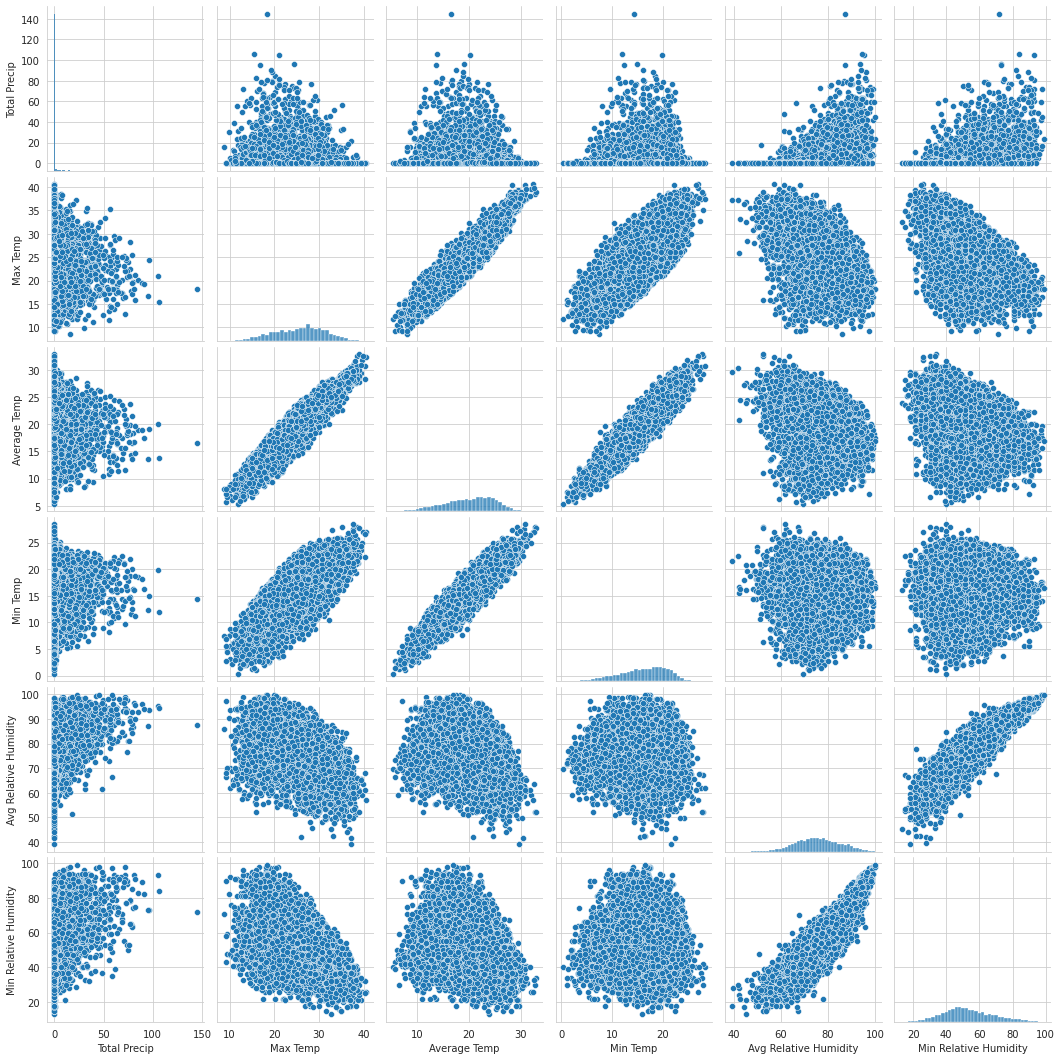

In [58]:
sns.pairplot(poaw)

In [49]:
by_year = poaw.groupby(pd.Grouper(key='Date',freq='Y')).mean()

<AxesSubplot:xlabel='Date'>

<Figure size 864x576 with 0 Axes>

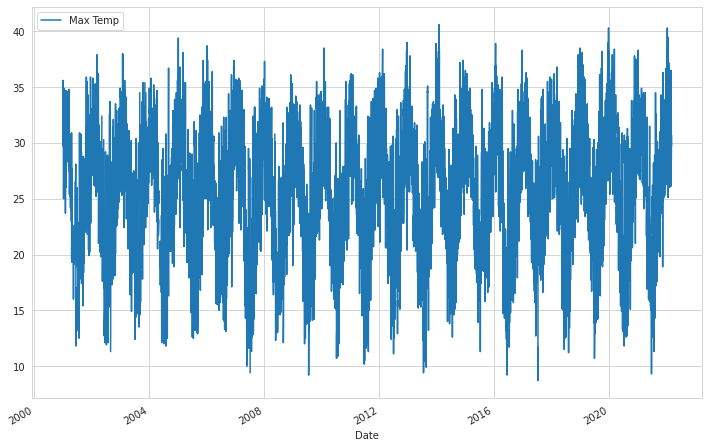

In [68]:
plt.figure(figsize=(12,8))
poaw.plot(y='Max Temp',figsize=(12,8))

In [92]:
#Separating by summers, winters and years (in the south hemisphere)
summer_start, summer_end = '-12-21', '-03-20'
winter_start, winter_end = '-05-21', '-09-22'
year_start, year_end = '-01-01', '-12-31'


#Initializing with 0 to make the index of years to reflect it's year
summers = [0]
winters = [0]
years = [0]

year = 2000

for i in range(1,23):
    
    year_i = str(year + i)
    
    summers.append(poaw.loc[year_i + summer_start:str(year+i+1) + summer_end]) #Correction because the summer ends in the next year
    winters.append(poaw.loc[year_i + winter_start:year_i + winter_end])
    years.append(poaw.loc[year_i + year_start:year_i + year_end])


In [95]:
summers[21]

,Total Precip,Max Temp,Average Temp,Min Temp,Avg Relative Humidity,Min Relative Humidity
Date,,,,,,
2021-12-21,0.0,31.4,24.758333,20.7,75.625000,38.0
2021-12-22,0.2,28.6,24.454167,22.1,71.083333,45.0
2021-12-23,0.0,27.9,22.870833,18.1,67.458333,49.0
2021-12-24,0.0,29.3,23.037500,18.1,66.583333,36.0
2021-12-25,0.0,32.6,24.175000,17.7,65.583333,23.0
...,...,...,...,...,...,...
2022-03-06,0.8,32.6,25.100000,23.8,85.333333,60.0
2022-03-07,56.4,35.2,25.170833,21.1,82.416667,51.0
2022-03-08,5.0,28.5,23.954167,20.9,80.416667,61.0


In [81]:
poaw.loc[('2001-12-21'):('2001'+summer_end)]

,Total Precip,Max Temp,Average Temp,Min Temp,Avg Relative Humidity,Min Relative Humidity
Date,,,,,,


<AxesSubplot:xlabel='Date'>

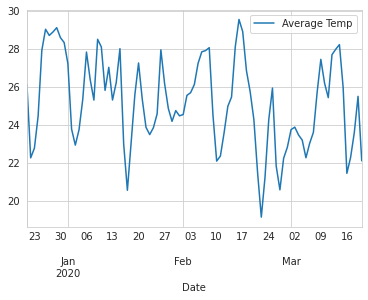

In [113]:
summers[19].plot(y='Average Temp')

([<matplotlib.axis.XTick at 0x7fae1fbde8e0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

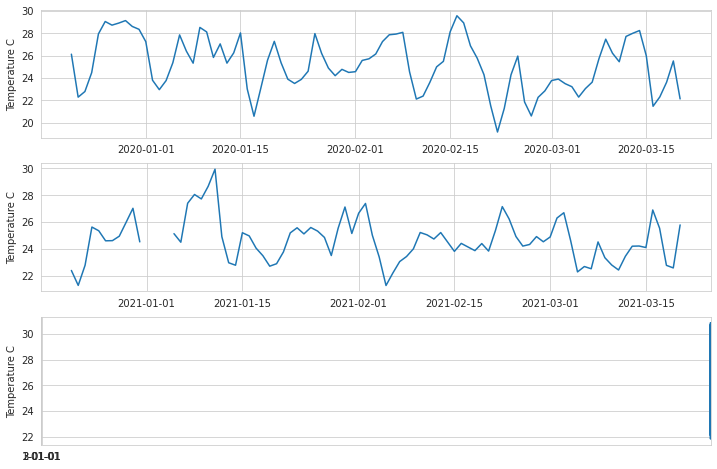

In [125]:
plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(summers[19]['Average Temp'])
plt.ylabel('Temperature C')    

plt.subplot(3,1,2)
plt.plot(summers[20]['Average Temp'])
plt.ylabel('Temperature C')

plt.subplot(3,1,3)
plt.plot(summers[21]['Average Temp'])
plt.ylabel('Temperature C')
plt.xticks(['1','2','3'])